EJEMPLO BÁSICO INSTALACIÓN

In [1]:
#! conda install typing-extensions=3.10
#pip install -e '.[notebook]' --no-warn-script-location --no-deps

In [2]:
#! conda install anaconda::gluonts

In [3]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [4]:
from dvats.all import *

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedInputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedOutputStream size changed, may indicate binary 


Octave is ready <oct2py.core.Oct2Py object at 0x7f674b823c40>

















In [5]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 20  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 100  # test set length: any positive integer



In [6]:
# Read data into pandas DataFrame
url = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)

In [7]:
df = pd.read_csv(url, index_col=0, parse_dates=True)

In [8]:
df.head()

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708


In [9]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

In [10]:
# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

In [11]:
# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [12]:
# Prepare pre-trained model by downloading model weights from huggingface hub
timer = dvats.utils.Time()
timer.start()
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)
timer.end()
timer.show()

[] Start: 1726582970.0363805 | End: 1726582971.4026387 | Duration: 1.366258144378662 seconds


1.366258144378662

In [13]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

In [14]:
input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [15]:
? input_it

Type:        generator
String form: <generator object InputDataset.__iter__ at 0x7f67442059a0>
Docstring:   <no docstring>

In [16]:
inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

In [17]:
test_data.input.test_data.dataset

PandasDataset<size=10, freq=H, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

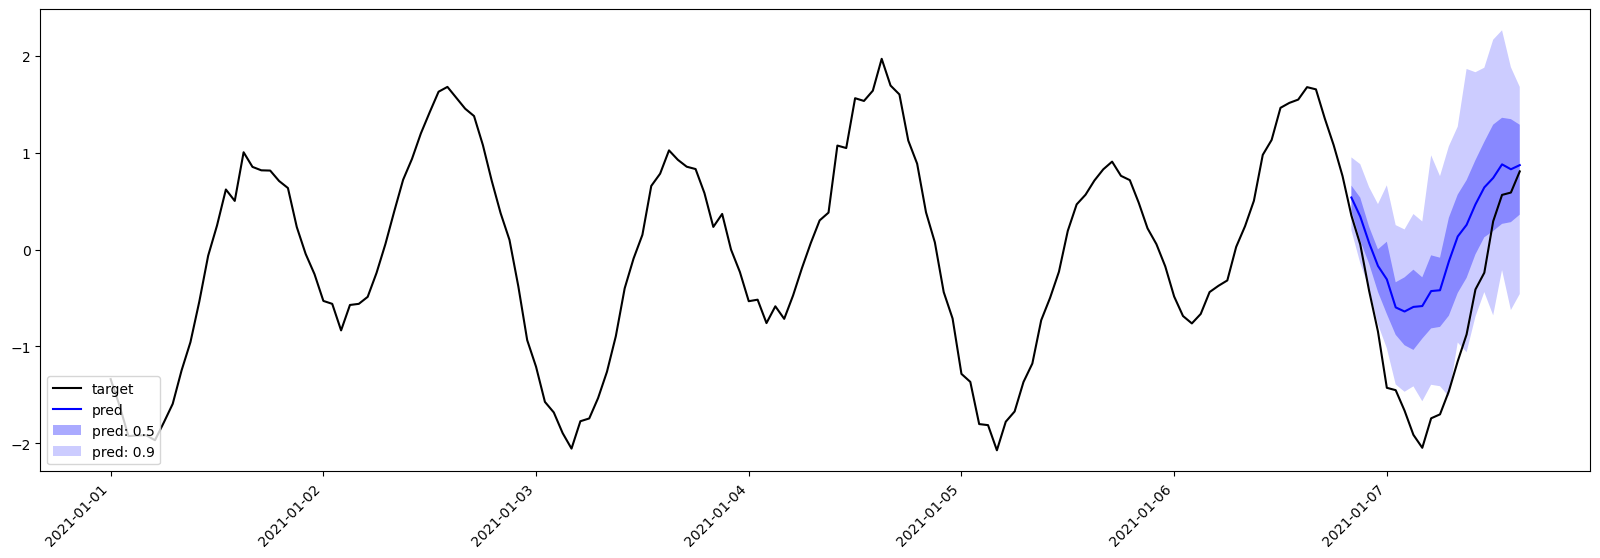

In [18]:
plot_single(
    inp, 
    label, 
    forecast, 
    context_length=200,
    name="pred",
    show_label=True,
)

In [19]:
plt.show()

# Dimensionality reduction

In [20]:
import numpy as np
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
embs = forecast.samples

In [22]:
#| export
# Define HDBSCAN parameters
umap_params = {
    'n_neighbors' : 10,
    'min_dist' : 0.01,
    'random_state': 1234
}
hdbscan_kwargs = {
    'min_cluster_size' : 5,
    'min_samples' : 7,
    'cluster_selection_epsilon' : 0.0001,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard' 
}
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax
# Color cluster & lines out
def plot_projections_clusters(prjs, clusters_labels, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    
    # Create a scatter plot for each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    print(unique_labels)
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}')
        #ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    
    #ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

In [23]:
prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)

GPU | Used mem: 2
GPU | Used mem: 24
GPU | Memory Usage: [█-------------------] 8%
-- cuml.UMAP -- False
GPU | Used mem: 2
GPU | Used mem: 24
GPU | Memory Usage: [█-------------------] 8%


In [24]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_

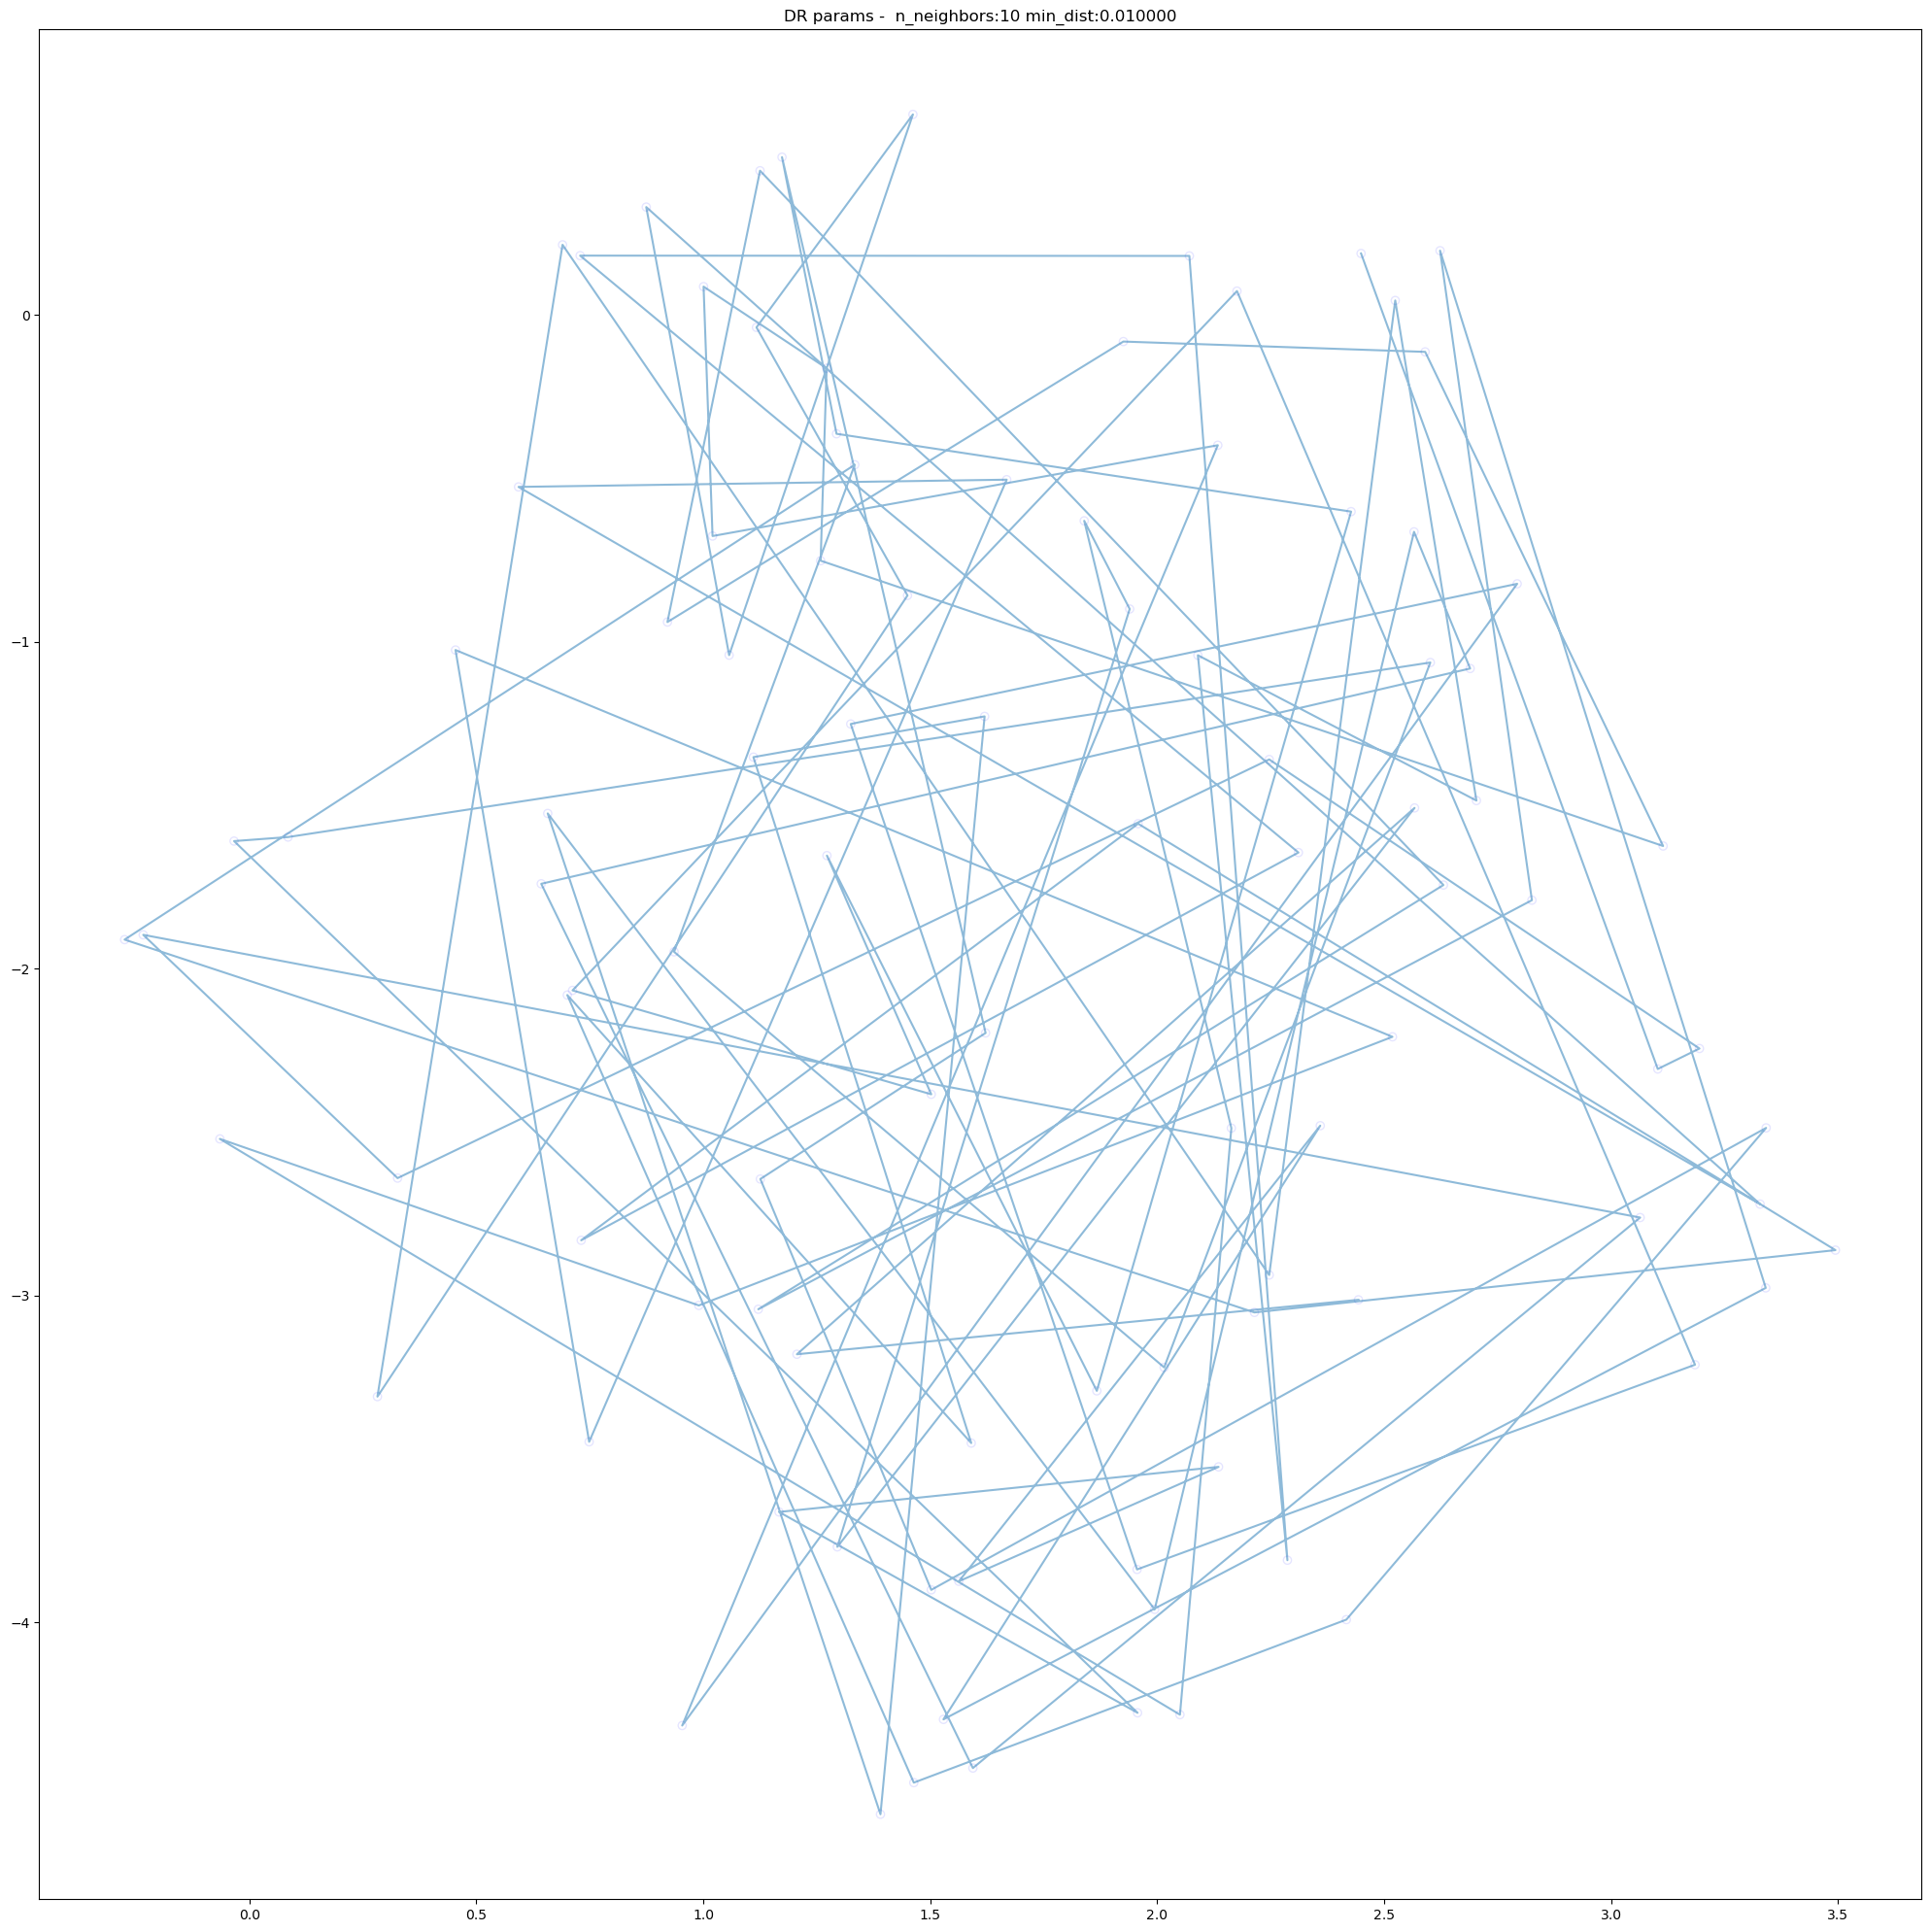

In [25]:
prjs_plt = plot_projections(prjs, umap_params)

[ 0 -1  1]


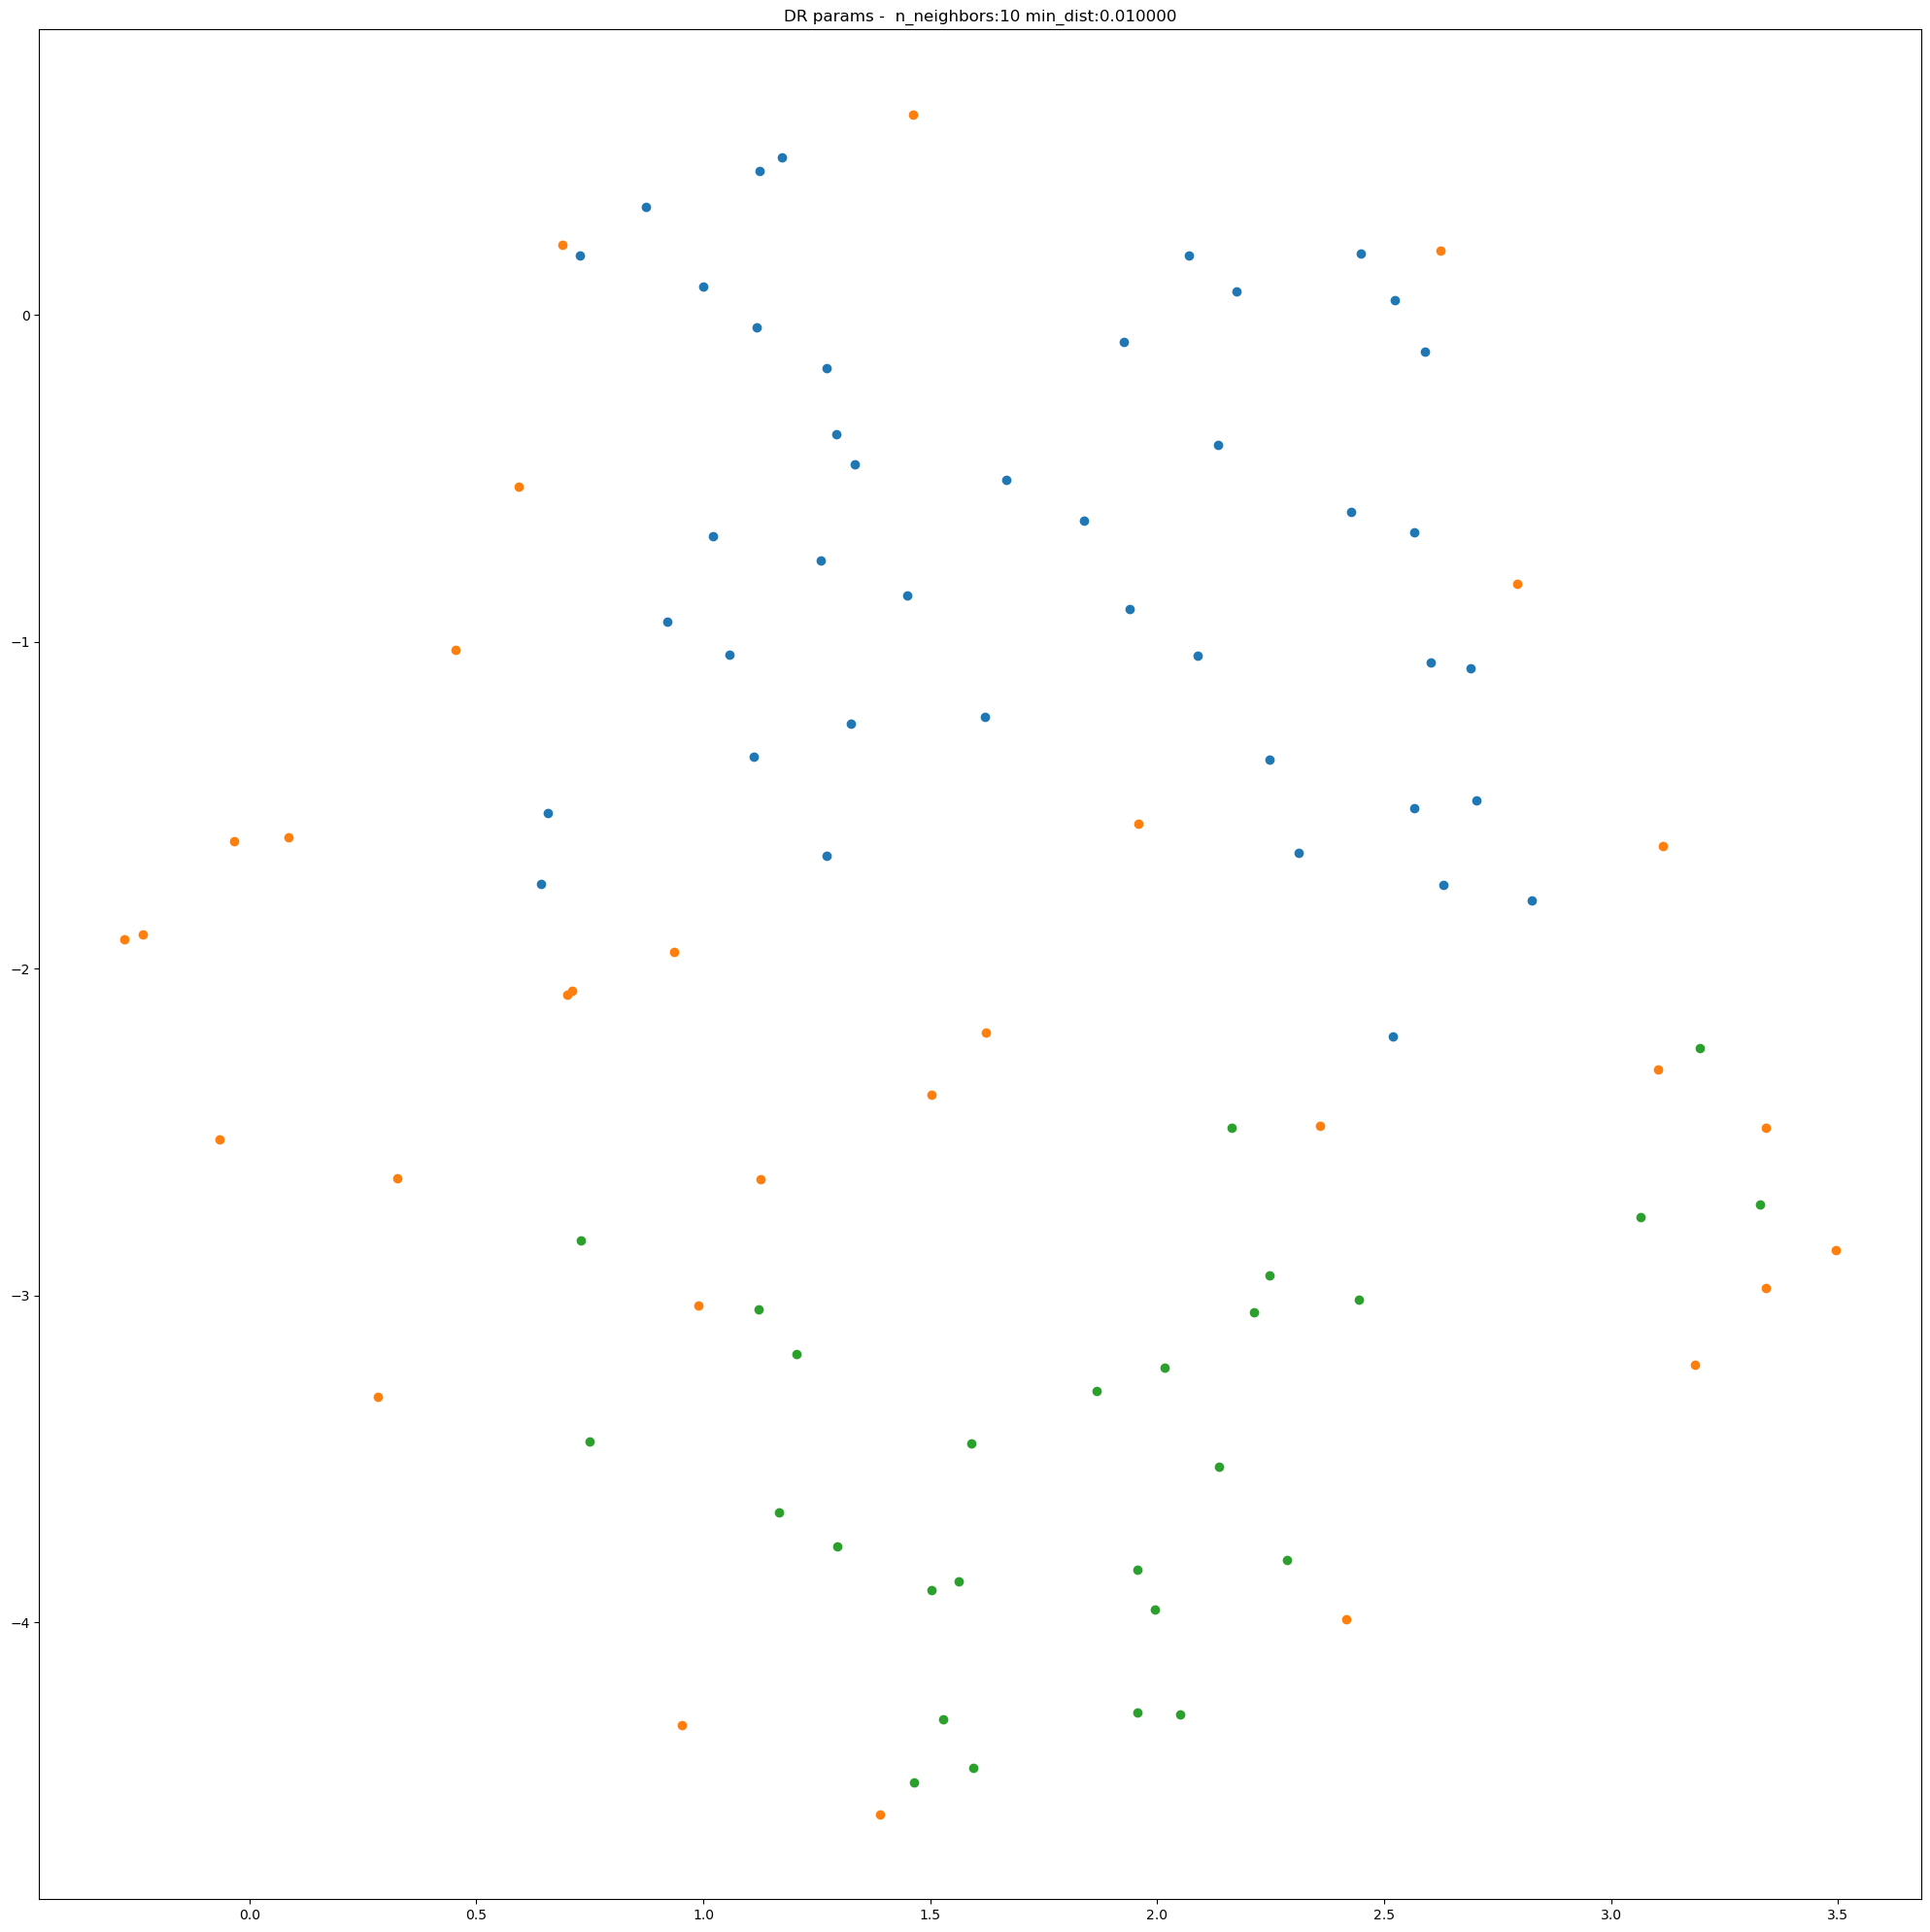

In [26]:
prjs_plt = plot_projections_clusters(prjs, clusters_labels, umap_params)

# Toy

In [27]:
#| export
verbose                       = 1  
show_plots                    = False
reset_kernel                  = False
pre_configured_case           = True 
case_id                       = 7 
frequency_factor              = 1
frequency_factor_change_alias = True 
cuda_device                   = 0

In [28]:
#| export
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad
base_path = Path.home()
import dvats.config as cfg_
config = cfg_.get_artifact_config_sd2a(verbose = 0)
if pre_configured_case: 
    print(f"Pre configured case id: {case_id}")
    cfg_.force_artifact_config_sd2a(
        config = config, 
        id = case_id, 
        verbose = verbose, 
        both = verbose > 0, 
        frequency_factor = frequency_factor, 
        frequency_factor_change_alias = frequency_factor_change_alias
    )
cfg_.show_attrdict(config)
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df_toy = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df_toy = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(os.path.expanduser(config.data_fpath))
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df_toy = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')
if config.time_col is not None:
    if verbose > 0: print("time_col: "+str(config.time_col))
    
    if isinstance(config.time_col, int): 
        if verbose > 0: print("Op 1: time_col int")
        datetime = df.iloc[:, config.time_col]
    
    elif isinstance(config.time_col, list): 
        if verbose > 0: print("Op 2: time_col list")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    
    index = pd.DatetimeIndex(datetime)
    
    if config.date_offset:
        index += config.date_offset
    
    df_toy = df_toy.set_index(index, drop=False)   
    
    #Delete Timestamp col
    col_name = df_toy.columns[config.time_col]
    
    if verbose > 0: print("... drop Timestamp col " + str(col_name))
    
    df_toy = df_toy.drop(col_name, axis=1)
    
if verbose > 0: display(df_toy.head())
df_toy = infer_or_inject_freq(
    df_toy, 
    injected_freq=config.freq, 
    start_date=config.start_date, 
    format=config.date_format
)
if verbose > 0: 
    print(f"--------> {df_toy.index.freq}")
# Subset of variables
if config.data_cols:
    if verbose > 0: print("data_cols: ", config.data_cols)
    df_toy = df_toy.iloc[:, config.data_cols]

if verbose > 0: print(f'Num. variables: {len(df_toy.columns)}')
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df_toy.replace(config.missing_values_constant, np.nan, inplace=True)
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df  # Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
    if df_testing.index.duplicated().any():
        print("There exist duplicated value(s) in the index dataframe.")
    else:
        if verbose > 0: print("There is no duplicated value in the index dataframe.")
else:
    if verbose > 0: print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
    testing_artifact = None


Pre configured case id: 7
Selecting  stumpy_toy_0
range_testing: None
missing_values_constant: None
date_format: %Y-%m-%d %H:%M:%S
use_wandb: True
start_date: None
time_col: None
test_split: None
date_offset: None
csv_config: {'header': None} -> {}
range_training: None
resampling_freq: None
freq: 1s
missing_values_technique: None
data_cols: [0] -> []
wandb_artifacts_path: ./data/wandb_artifacts
joining_train_test: False
artifact_name: PulsusParadoxus-SP02 -> toy
data_fpath: ~/data/PulsusParadoxusSP02_30_10000.csv -> ~/data/toy.csv
normalize_training: False
artifact_name: toy
csv_config: {}
data_cols: []
data_fpath: ~/data/toy.csv
date_format: %Y-%m-%d %H:%M:%S
date_offset: None
freq: 1s
joining_train_test: False
missing_values_technique: None
missing_values_constant: None
normalize_training: False
range_training: None
range_testing: None
resampling_freq: None
start_date: None
test_split: None
time_col: None
use_wandb: True
wandb_artifacts_path: ./data/wandb_artifacts


,T3,T2,T1
0,0.741822,0.637180,0.565117
1,0.739731,0.629415,0.493513
2,0.718757,0.539220,0.469350
3,0.730169,0.577670,0.444100
4,0.752406,0.570180,0.373008


--------> <Second>
Num. variables: 3
rg None | test_split None


In [29]:
ds_toy = PandasDataset(dict(df_toy))

In [30]:
df_toy.shape

(550, 3)

In [31]:
df_toy.head()

,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


In [32]:
print(df_toy.index.freq)

<Second>


In [33]:
df_toy = df_toy.to_period(freq=df.index.freq)

In [100]:
SIZE_toy = "small"  # model size: choose from {'small', 'base', 'large'}
PDT_toy  = 30  # prediction length: any positive integer
CTX_toy  = 60  # context length: any positive integer
PSZ_toy  = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ_toy  = 64  # batch size: any positive integer
TEST_toy = 225  # test set length: any positive integer

In [101]:
train_toy, test_template_toy = split(
    ds_toy, offset=-TEST_toy
)

In [35]:
train_toy.dataset.freq

'S'

In [36]:
test_template_toy.dataset.freq

'S'

In [37]:
? train_toy

Type:        TrainingDataset
String form: TrainingDataset(dataset=PandasDataset<size=3, freq=S, num_feat_dynamic_real=0, num_past_feat_dyna <...> ic_real=0, num_feat_static_cat=0, static_cardinalities=[]>, splitter=OffsetSplitter(offset=-100))
Length:      3
File:        ~/.local/lib/python3.10/site-packages/gluonts/dataset/split.py
Docstring:   TrainingDataset(dataset: gluonts.dataset.Dataset, splitter: gluonts.dataset.split.AbstractBaseSplitter)

## Forecast

In [102]:
# Construct rolling window evaluation
test_data_toy = test_template_toy.generate_instances(
    prediction_length=PDT_toy,  # number of time steps for each prediction
    windows=TEST_toy // PDT_toy,  # number of windows in rolling window evaluation
    distance=PDT_toy,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [103]:
# Prepare pre-trained model by downloading model weights from huggingface hub
timer = dvats.utils.Time()
timer.start()
model_toy = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT_toy,
    context_length=CTX_toy,
    patch_size=PSZ_toy,
    num_samples=100,
    target_dim=1, # por qué aquí no puedo poner las tres?
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)
timer.end()
timer.show()

[] Start: 1726584514.784529 | End: 1726584515.2019632 | Duration: 0.4174342155456543 seconds


0.4174342155456543

In [104]:
predictor_toy = model.create_predictor(batch_size=BSZ_toy)
forecasts_toy = predictor_toy.predict(test_data_toy.input)

In [105]:
test_data_toy.input.test_data.dataset

PandasDataset<size=3, freq=S, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [106]:
input_it = iter(test_data_toy.input)
label_it = iter(test_data_toy.label)
forecast_it = iter(forecasts_toy)

In [107]:
inp_toy = next(input_it)
label_toy = next(label_it)
forecast_toy = next(forecast_it)

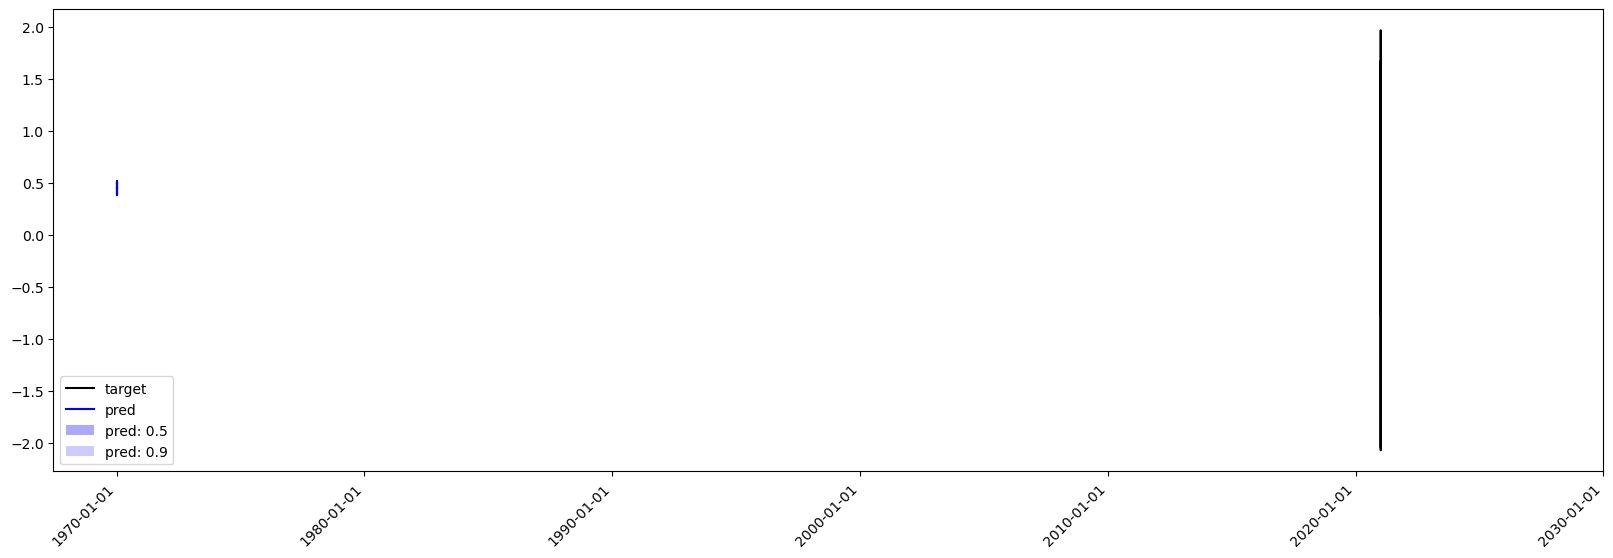

In [108]:
plot_single(
    inp, 
    label, 
    forecast_toy, 
    context_length=CTX_toy,
    name="pred",
    show_label=True,
)
plt.show()

In [46]:
from uni2ts.eval_util.plot import plot_next_multi

In [68]:
import matplotlib.pyplot as plt
import numpy as np


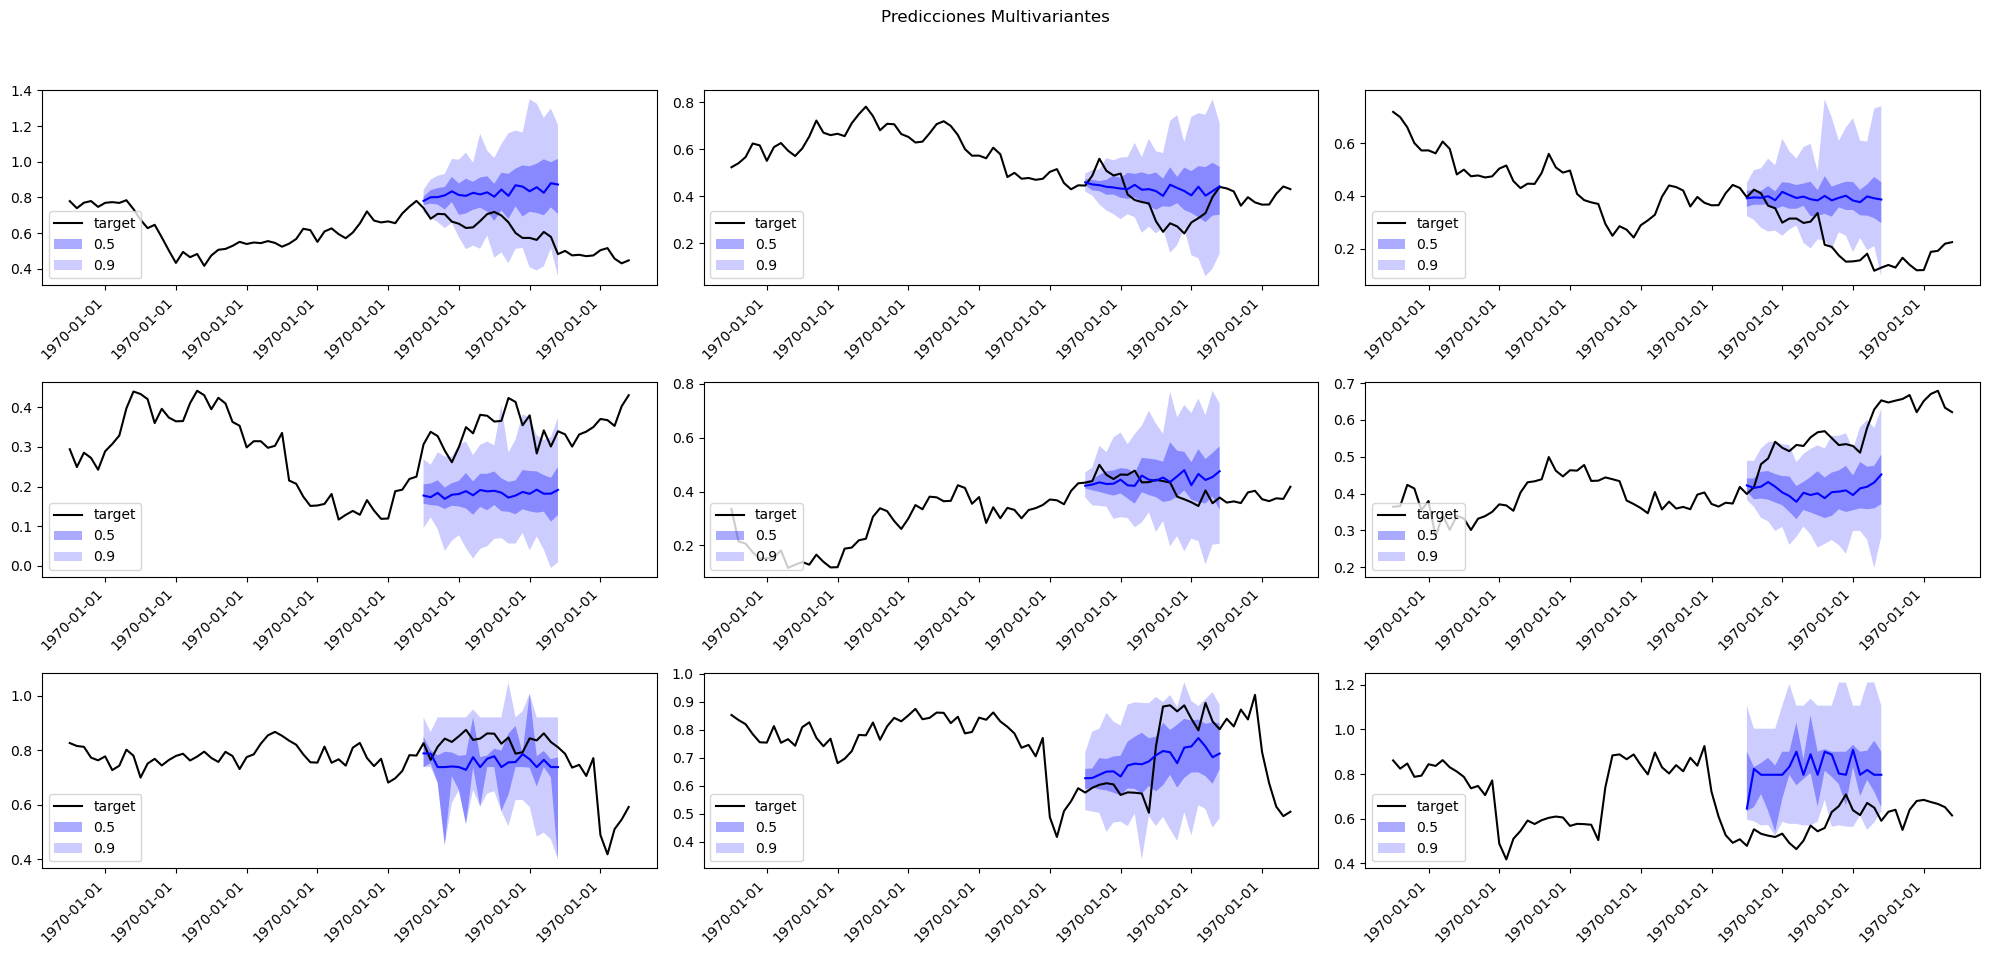

In [109]:

# Suponiendo que tienes 3 variables y quieres visualizar 5 predicciones
fig, axes = plt.subplots(3, 3, figsize=(20, 10))  # 3 filas (una por variable), 5 columnas (una por predicción)
fig.suptitle('Predicciones Multivariantes')

# Llamada a plot_next_multi
plot_next_multi(
    axes=axes,
    input_it=input_it,  # Asegúrate de que este iterador proporcione los datos correctos
    label_it=label_it,
    forecast_it=forecast_it,
    context_length=CTX_toy,
    intervals=(0.5, 0.9),  # Intervalos de confianza
    show_label=True
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [78]:
embs_toy = forecast_toy.samples

In [112]:
prjs_toy = get_UMAP_prjs(embs_toy, cpu=False, **umap_params)

GPU | Used mem: 4
GPU | Used mem: 24
GPU | Memory Usage: [███-----------------] 17%
-- cuml.UMAP -- False
GPU | Used mem: 4
GPU | Used mem: 24
GPU | Memory Usage: [███-----------------] 17%


In [113]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_toy)
clusters_labels = clusters.labels_

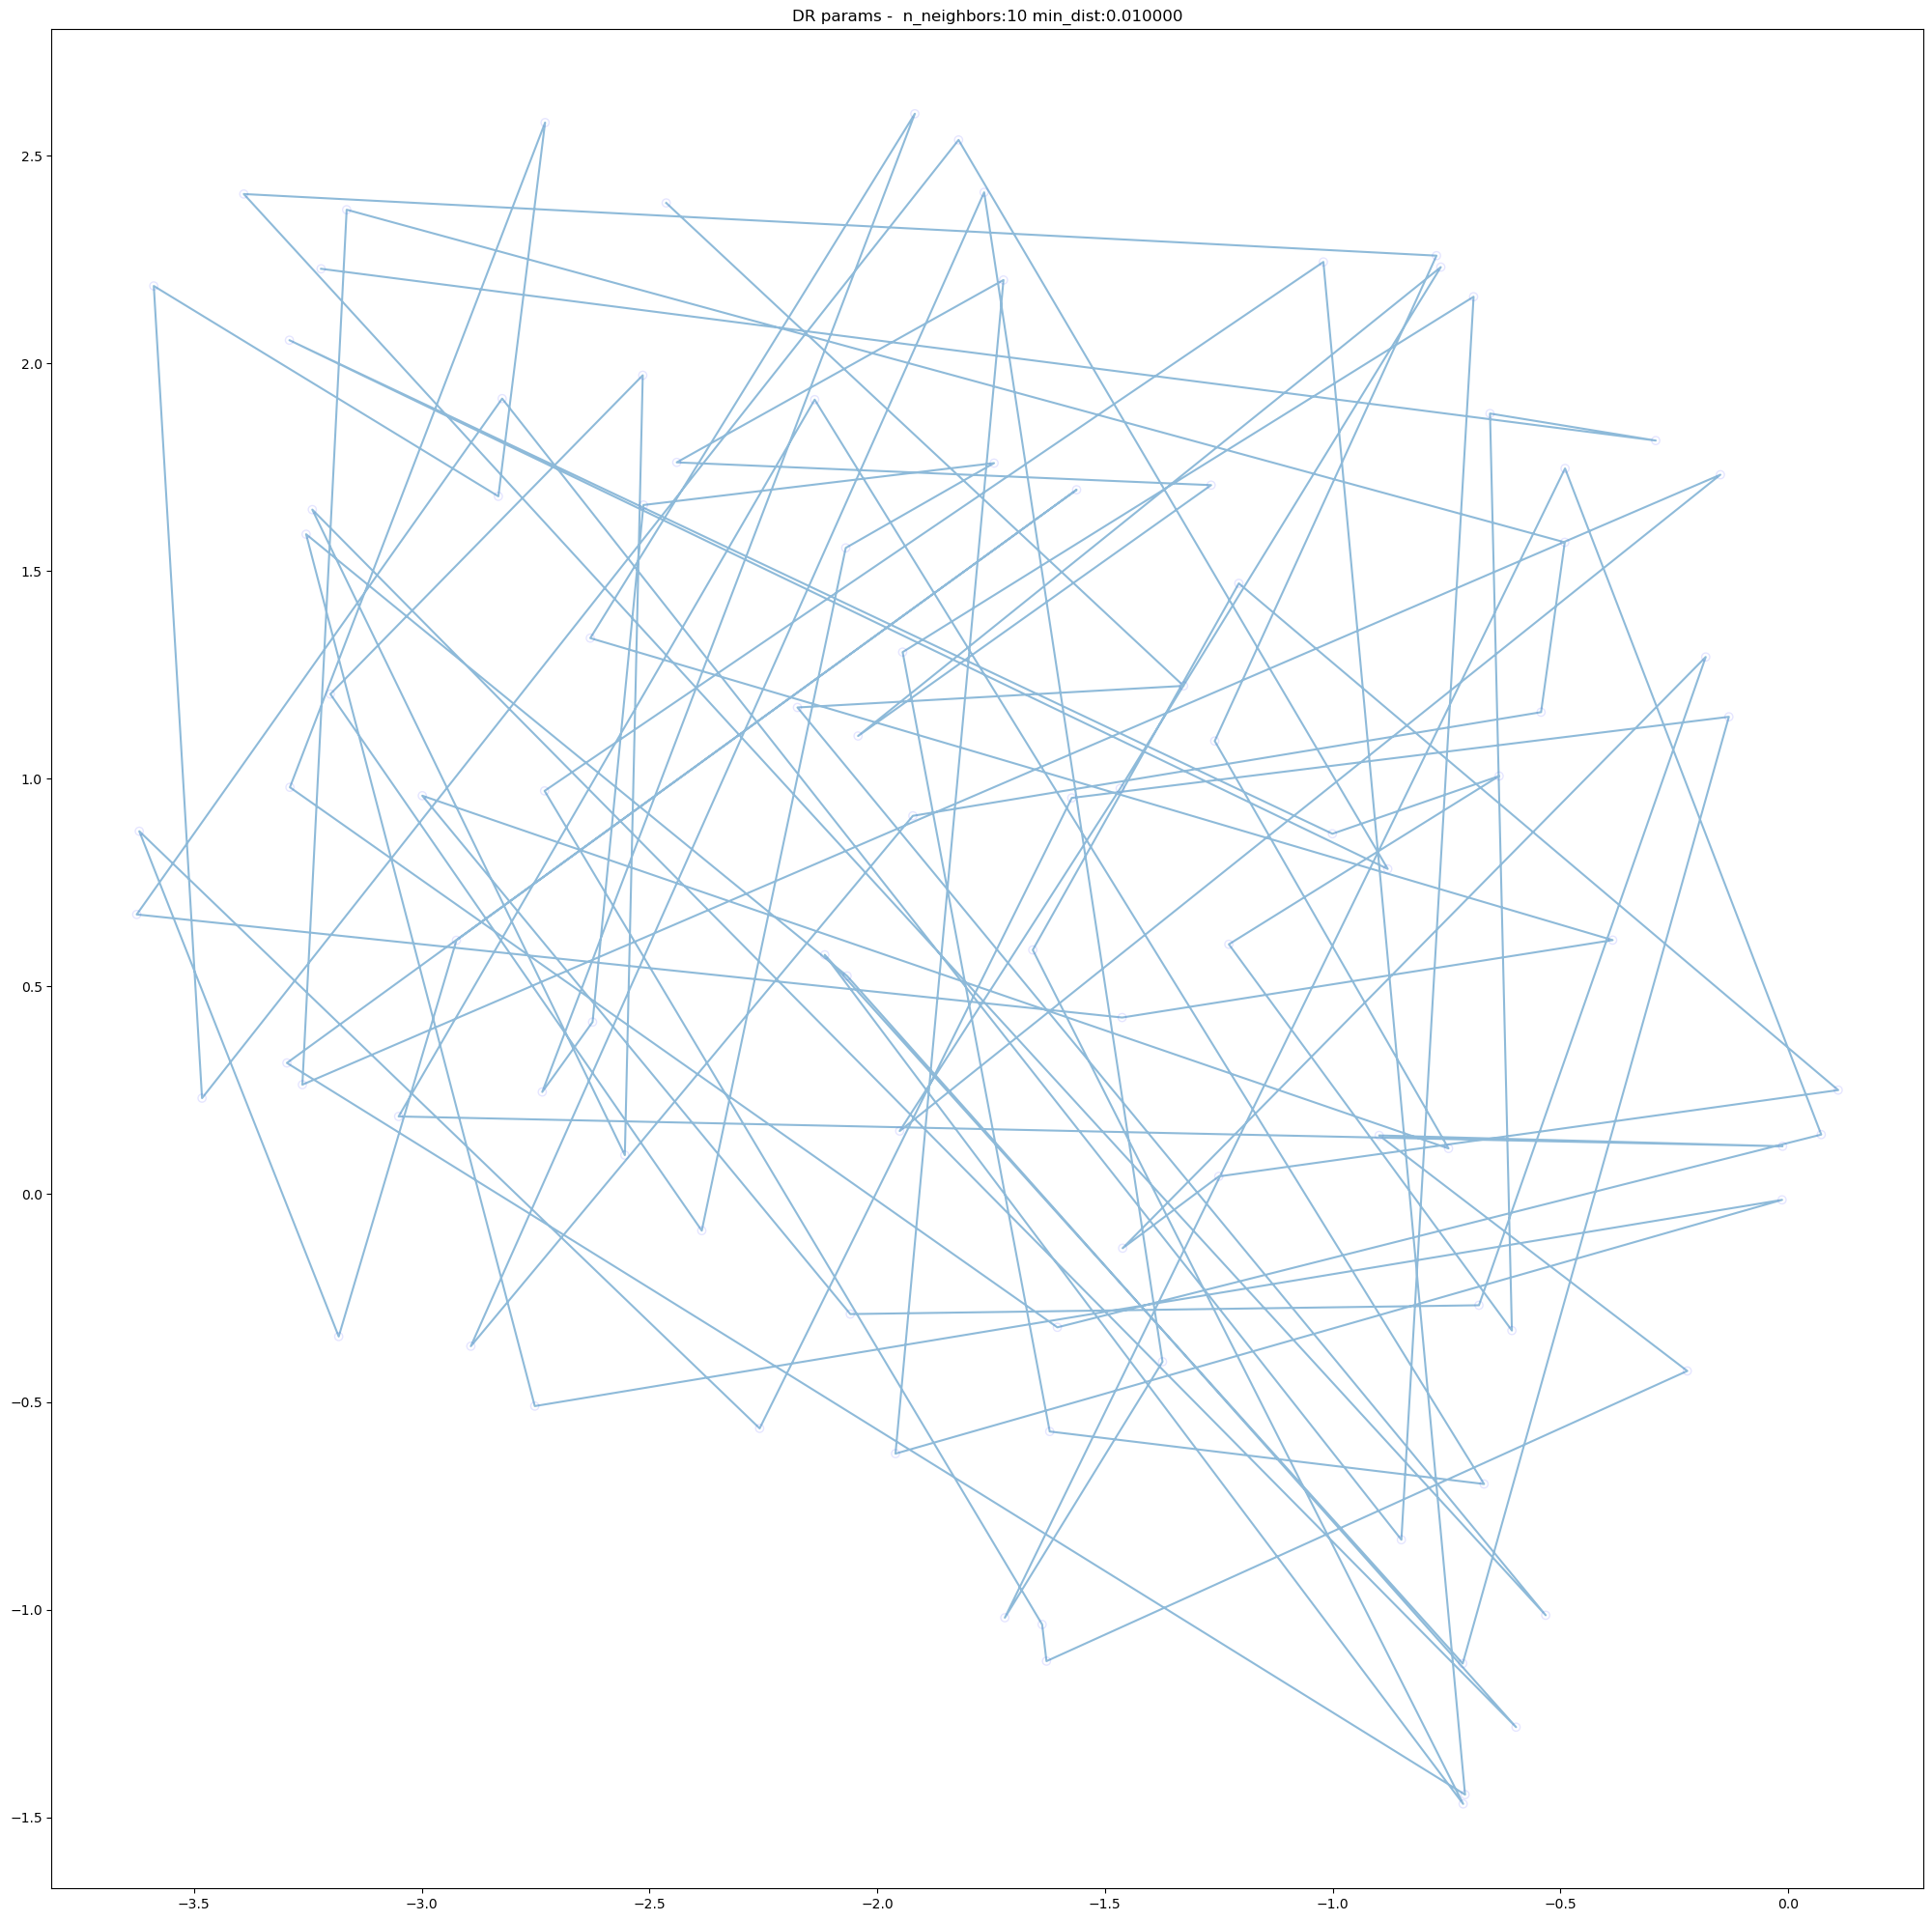

In [114]:
prjs_plt_toy = plot_projections(prjs_toy, umap_params)

[-1  1  0]


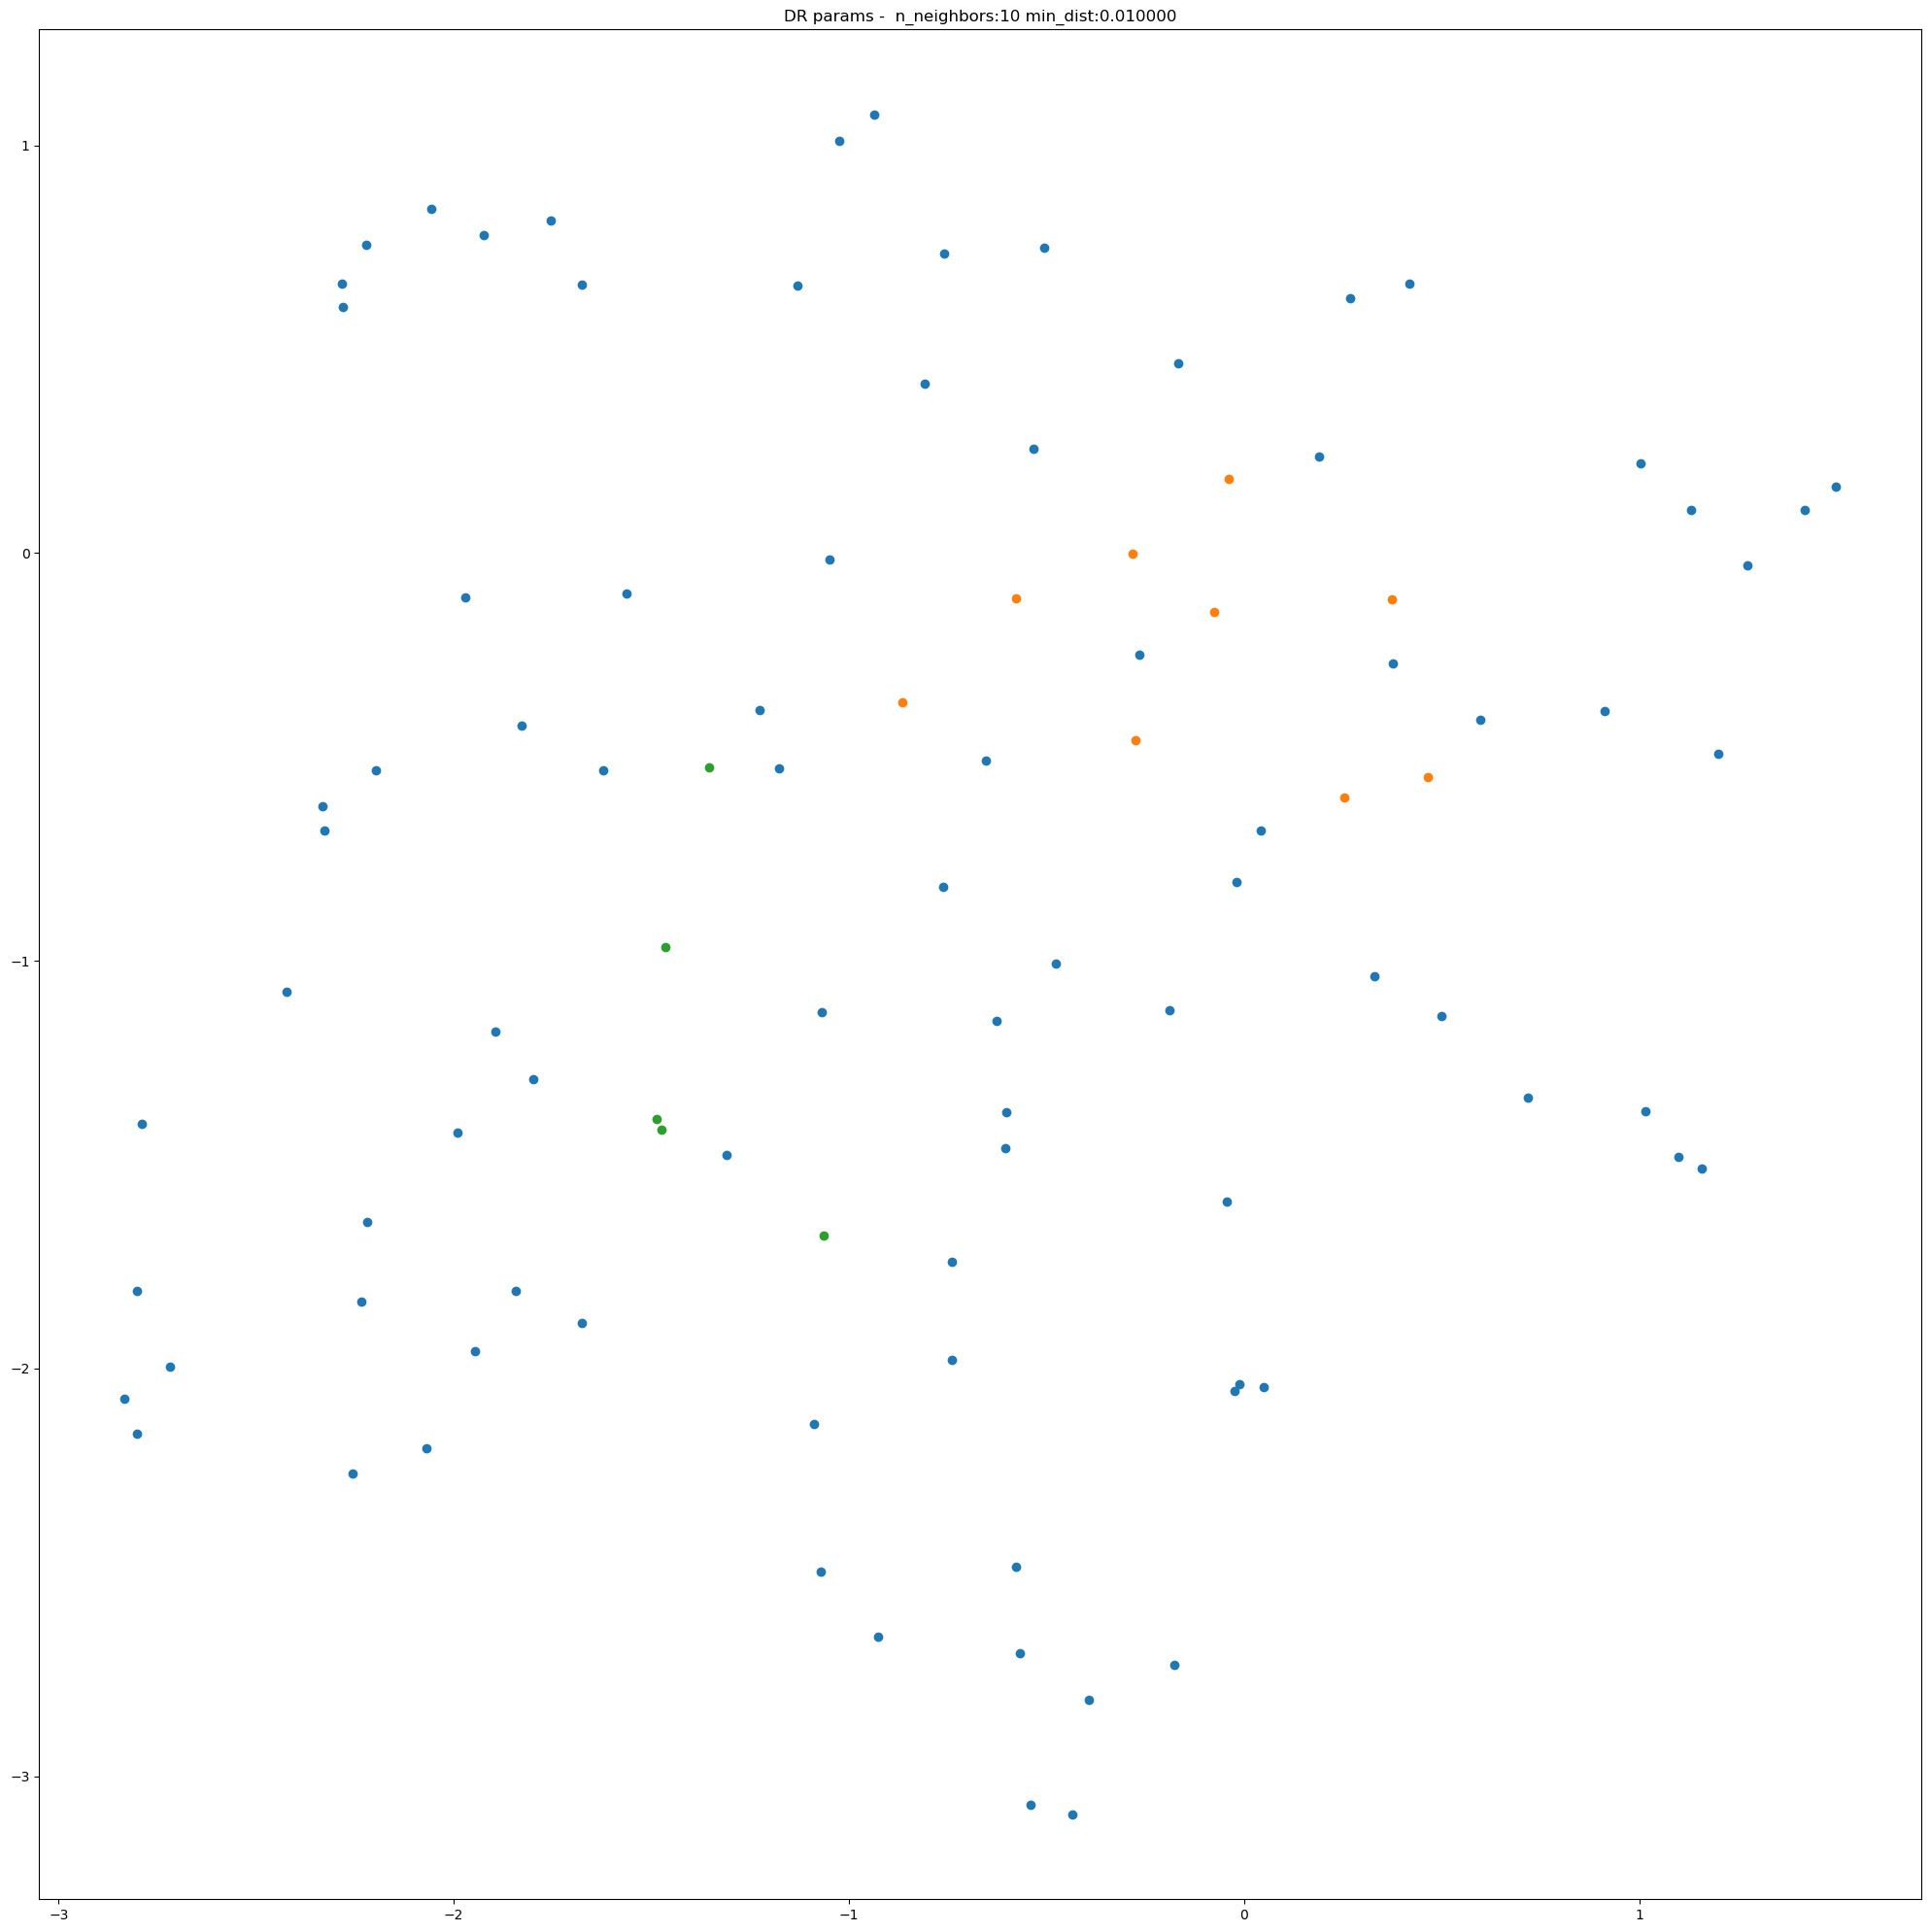

In [83]:
prjs_plt_toy = plot_projections_clusters(prjs_toy, clusters_labels, umap_params)

Mirando información

In [84]:
? model_toy

Signature:        model_toy(*args, **kwargs)
Type:            MoiraiForecast
String form:    
MoiraiForecast(
           (module): MoiraiModule(
           (mask_encoding): Embedding(1, 384)
           (scaler): Pa <...> s=(8, 16, 32, 64, 128), bias=True, dtype=torch.float32)
           )
           )
           )
           )
           )
           )
File:            ~/work/nbs_pipeline/uni2ts/src/uni2ts/model/moirai/forecast.py
Docstring:       <no docstring>
Class docstring: Hooks to be used in LightningModule.

In [85]:
? MoiraiForecast

Init signature:
 MoiraiForecast(
    prediction_length: int,
    target_dim: int,
    feat_dynamic_real_dim: int,
    past_feat_dynamic_real_dim: int,
    context_length: int,
    module_kwargs: Optional[dict[str, Any]] = None,
    module: Optional[uni2ts.model.moirai.module.MoiraiModule] = None,
    patch_size: int | str = 'auto',
    num_samples: int = 100,
)
Docstring:      Hooks to be used in LightningModule.
File:           ~/work/nbs_pipeline/uni2ts/src/uni2ts/model/moirai/forecast.py
Type:           type
Subclasses:     